In [4]:
from unet import UNet
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from utils.dice_score import dice_loss
from utils.dice_score import multiclass_dice_coeff

/Users/alain/opt/miniconda3/envs/iaenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [5]:
# cargando el dataset de imágenes
dir_img = "/Users/alain/Documents/desarrollo/Fiber-Unet/datasets/wormbodies/images_filtered/"
# dir_mask = "/data/aalejo/data_wormbodies/BBBC010_v1_foreground/"
dir_mask = "/Users/alain/Documents/desarrollo/Fiber-Unet/datasets/wormbodies/foreground_overlapping/"

# img_transforms = transforms.Compose([
img_transforms = transforms.RandomChoice([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5],std=[0.5])
    # transforms.Normalize(mean=[0.114, 0.114, 0.114],std=[0.237, 0.237, 0.237])
])

dataset = BasicDataset(dir_img, dir_mask, scale=1, mask_suffix='_ground_truth', transforms=img_transforms)

val_percent = 0.2
batch_size = 4

n_val = int(len(dataset) * val_percent)
n_test = 5
n_train = len(dataset) - n_val - n_test

train, val, test = random_split(dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [3]:
# print(f'Test batches: {len(test_loader)}')

In [6]:
lote = next(iter(test_loader))

print(lote['image'].shape)
print(lote['mask'].shape)
# print(lote['path'])

torch.Size([4, 1, 350, 350])
torch.Size([4, 350, 350])


tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0275, 0.0314, 0.0353,
        0.0392, 0.0431])
tensor([0, 1, 2])


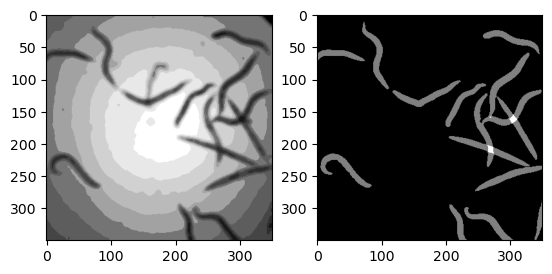

In [7]:
# unnormalize = transforms.Normalize(mean=[-0.114/0.237, -0.114/0.237, -0.114/0.237],std=[1/0.237, 1/0.237, 1/0.237])
# lote_img = unnormalize(lote['image'][2]).numpy().transpose(1,2,0)

# lote_img = lote['image'][2].numpy().transpose(1,2,0)
print(lote['image'][0].squeeze().unique())
print(lote['mask'][0].squeeze().unique())

#image = lote['image'][0].numpy().transpose(1,2,0)
#print(np.unique(image))

#plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(lote['image'][0].squeeze(), cmap='gray')
plt.subplot(122), plt.imshow(lote['mask'][0].squeeze(), cmap='gray')
plt.show()

# Trainning

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

mps


In [55]:
print(torch.__version__)

1.13.0.dev20220927


In [9]:
from IPython.display import clear_output

net = UNet(n_channels=1, n_classes=3, bilinear=False)

# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     net = nn.DataParallel(net)
# net.to(device=device)

clear_output()

In [8]:
from torchsummary import summary

summary(net, (1,350,350))

# clear_output()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 350, 350]             576
       BatchNorm2d-2         [-1, 64, 350, 350]             128
              ReLU-3         [-1, 64, 350, 350]               0
            Conv2d-4         [-1, 64, 350, 350]          36,864
       BatchNorm2d-5         [-1, 64, 350, 350]             128
              ReLU-6         [-1, 64, 350, 350]               0
        DoubleConv-7         [-1, 64, 350, 350]               0
         MaxPool2d-8         [-1, 64, 175, 175]               0
            Conv2d-9        [-1, 128, 175, 175]          73,728
      BatchNorm2d-10        [-1, 128, 175, 175]             256
             ReLU-11        [-1, 128, 175, 175]               0
           Conv2d-12        [-1, 128, 175, 175]         147,456
      BatchNorm2d-13        [-1, 128, 175, 175]             256
             ReLU-14        [-1, 128, 1

In [10]:
net.to(device=device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [65]:
# from utils.train_utils import train_net


def train_net(net, target='MODEL.pth', epochs=100):
    """ funcion de entrenamiento """
    
    # criterion = nn.SmoothL1Loss()
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()

    # hiperparametros:
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.96)

    # loss history:
    train_losses = []
    val_losses = []

    # early stopping vars:
    best_prec1 = np.Inf #1e6
    epochs_no_improve = 0
    n_epochs_stop = 10

    # train loop:
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0

        with tqdm(total=n_train, desc=f'Train Epoch {epoch+1}/{epochs}') as pbar:
            for batch in train_loader:
                imgs, true_masks = batch['image'], batch['mask']

                imgs = imgs.to(device=device, dtype=torch.float32)
                # true_masks = true_masks.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                masks_pred = net(imgs)

                # print('true_masks.shape', true_masks.shape)
                # print('masks_pred.shape', masks_pred.shape)
                # break
                tmp = F.one_hot(true_masks, net.n_classes).permute(0,3,1,2).float()
                print(tmp.unique())
                return
                
                loss = criterion(masks_pred, true_masks) \
                        + dice_loss(F.softmax(masks_pred, dim=1).float(),
                                    F.one_hot(true_masks, net.n_classes).permute(0,3,1,2).float(),
                                    multiclass=True)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(imgs.shape[0])
                # epoch_loss += loss.item() * imgs.size(0)
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                
        # train_losses.append(epoch_loss/len(train))
        train_losses.append(epoch_loss)
        
        #validacion:
        net.eval()
        epoch_loss = 0
        dice_score = 0
        
        with tqdm(total=n_val, desc=f'Val Epoch {epoch+1}/{epochs}') as pbar:
            for batch in val_loader:
                imgs, true_masks = batch['image'], batch['mask']
                imgs = imgs.to(device=device, dtype=torch.float32)
                # true_masks = true_masks.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                print(torch.unique(true_masks))
                
                # true_masks = F.one_hot(true_masks, net.n_classes).permute(0,3,1,2).float()
                true_masks = F.one_hot(true_masks, net.n_classes).permute(0,3,1,2)
                
                print(torch.unique(true_masks))

                with torch.no_grad():
                    masks_pred = net(imgs)
                    # loss = criterion(masks_pred, true_masks)

                    print(masks_pred.shape)

                    # masks_pred = F.softmax(masks_pred,dim=1)

                    # print(masks_pred.shape)
                    # print(masks_pred)
                    print("argmax")
                    masks_pred = masks_pred.argmax(dim=1)

                    print(masks_pred.shape)
                    print(masks_pred)
                    print(torch.unique(masks_pred))

                    masks_pred = F.one_hot(masks_pred, net.n_classes)#.permute(0,3,1,2).float()

                    print("one hot")
                    print(masks_pred.shape)
                    print(masks_pred)
                    print(torch.unique(masks_pred))
                    return

                    dice_score += multiclass_dice_coeff(masks_pred[:,1:,...],true_masks[:,1:,...], reduce_batch_first=False)
                    # print("******")
                    # print(dice_score.item())
                    # return
                
                # epoch_loss += loss.item() * imgs.size(0)
                epoch_loss += dice_score.item()
                
                # pbar.set_postfix(**{'loss (batch)': loss.item()})
                pbar.set_postfix(**{'loss (batch)': dice_score.item()})
                pbar.update(imgs.shape[0])

        # val_losses.append(epoch_loss/len(val))
        val_losses.append(epoch_loss)
        
        if (epoch+1) % 10 == 0:
            scheduler.step()

        # se guarda el modelo si es mejor que el anterior:
        prec1 = epoch_loss/n_val
        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        
        if is_best:
            epochs_no_improve = 0
            torch.save(net.state_dict(), target) 
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print('Early stopping!')
                break 

    print(f'The best Loss (train): {min(train_losses)}')                
    print(f'The best Loss (val): {min(val_losses)}')
    
    
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    return min(train_losses),best_prec1

In [66]:

lr = 10**-3
weight_decay = 5*(10**-6)

error_train,error = train_net(net, 'checkpoints/MODEL_unet3.pth', epochs = 500)
# error_train_list.append(error_train)
# error_list.append(error)

Train Epoch 1/500:   0%|          | 0/75 [00:00<?, ?it/s]

tensor([0.0000e+00, 1.0000e+00, 1.0654e+09, 1.3169e+09, 1.3189e+09, 1.3210e+09,
        1.5853e+09, 1.5873e+09, 1.5894e+09, 4.5757e+18, 5.6560e+18, 5.6647e+18,
        5.6737e+18, 6.8089e+18, 6.8176e+18, 6.8266e+18], device='mps:0')


Train Epoch 1/500:   0%|          | 0/75 [00:14<?, ?it/s]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# mini batch de prueba
test_images = enumerate(test_loader)

q = next(test_images)

print(q[1]['image'].shape)
print(q[1]['mask'].shape)

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    # plt.imshow(q[1]['mask'][i][0], cmap='gray')
    plt.imshow(q[1]['mask'][i], cmap='gray')

print('ground truth')
plt.show()

print(type(q))

#side = 5
with torch.no_grad():
    # output = net(q[1]['image'].cuda())
    output = net(q[1]['image'].to(device))

print(output.shape)


    
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.imshow(output.cpu()[i][0], cmap='gray')
    plt.title("max value: " + str(output.cpu()[i][0].max()))
    # print(np.unique(output.cpu()[i][1]))

    plt.subplot(3, 4, i+5)
    plt.imshow(output.cpu()[i][1], cmap='gray')
    plt.title("max value: " + str(output.cpu()[i][1].max()))
    # print(np.unique(output.cpu()[i][1]))

    plt.subplot(3, 4, i+9)
    plt.imshow(output.cpu()[i][2], cmap='gray')
    plt.title("max value: " + str(output.cpu()[i][2].max()))
    # print(np.unique(output.cpu()[i][1]))

    
print('predictions')
plt.show()

torch.Size([4, 350, 350])


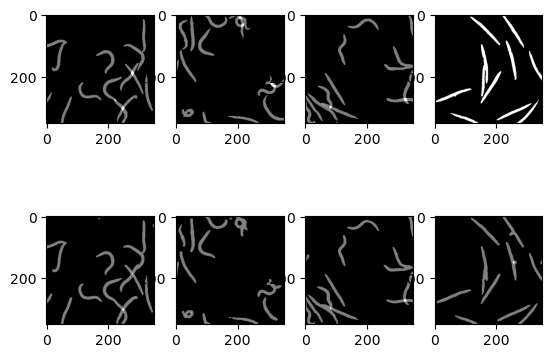

In [22]:
predictions = torch.nn.functional.softmax(output, dim=1)
pred_labels = torch.argmax(predictions, dim=1) 
pred_labels = pred_labels.float()

# t2l = { label.trainId : label for label in reversed(labels) }
# # Remapping the labels
# pred_labels = pred_labels.to('cpu')
# pred_labels.apply_(lambda x: t2l[x].id)
# pred_labels = pred_labels.to(device)

print(pred_labels.shape)

#plt.figure(figsize=(80))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(q[1]['mask'][i], cmap='gray')
    plt.subplot(2,4,i+5)
    plt.imshow(pred_labels.cpu()[i], cmap='gray')

plt.show()


(198, 190, 1)
(198, 190, 1)
(198, 190, 1)
(198, 190, 1)
(198, 190, 1)


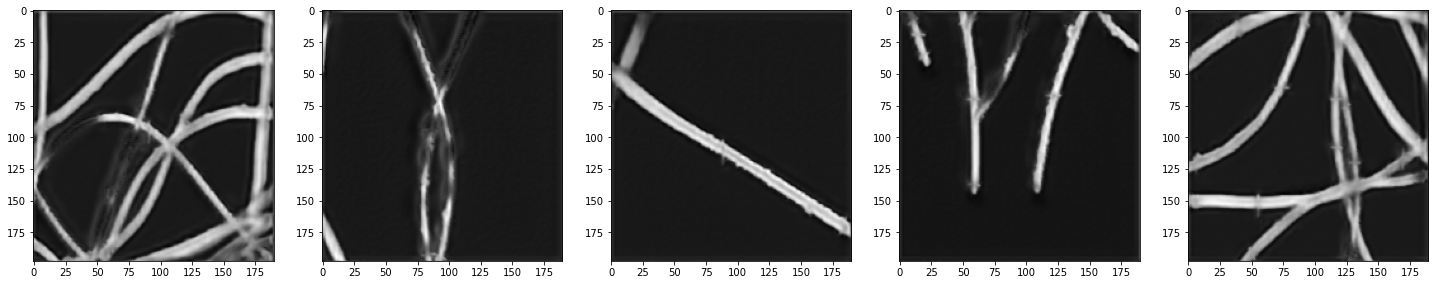

In [25]:
import os
from PIL import Image
import cv2

dir_images = "../dmnet/data/ofda/raw/"
tensores = []

for file in os.listdir(dir_images):
    if not file.startswith('.'):
        #image = cv2.imread(dir_images + file, 0)
        image = Image.open(dir_images + file).convert('L')
        image = np.array(image)
        image = np.expand_dims(image, axis=2)
        
        print(image.shape)

        image = image.transpose((2,0,1))
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image / 255
        
        tensor = torch.from_numpy(image).type(torch.FloatTensor)
        tensores.append(tensor)

images = torch.cat([tensor.unsqueeze(0) for tensor in tensores])

with torch.no_grad():
    images = images.to(device)
    output = net(images)
    
predictions = output.cpu().numpy()
predictions = [predictions[i].squeeze() for i in range(predictions.shape[0])]

plt.figure(figsize=(5*5,5))

for i, dm in enumerate(predictions):
    plt.subplot(1,5,i+1), plt.imshow(dm, cmap='gray')
    
plt.show()